Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [1]:
NAME = "Weronika Pawlak"

---

# Bayesowskie Sieci Neuronowe (ang. *Bayesian Neural Networks*)

BSN (Bayesowskie Sieci Neuronowe) są rozszerzeniem tradycyjnych sieci neuronowych o elementy wnioskowania i uczenia Bayesowskiego. Wśród zalet tych sieci możemy wskazać:
- możliwość pomiaru niepewności modelu (*uncertainty*) dla predykcji (przy różnych poziomach pewności - ang. *confidence levels*)
- istnieje możliwość zakodowanie wiedzy apriori na temat rozkładu wag sieci

## Podejście Bayesowskie

W przypadku zwykłych sieci neuronowych parametry (wagi) sieci estymujemy metodą Maximum Likelihood, która maksymalizuje prawdopodobieństwo obserwowania danych $\mathcal{D}$ pod warunkiem parametrów $\mathbf{w}$:

$$
\text{arg max}_\theta p(\mathcal{D}|\mathbf{w})
$$

Skutkiem tego jest punktowa estymata parametrów, która nie pozwala modelować niepewności. Możemy jednak wykorzystać twierdzenie Bayesa i przekształcić problem do **uczenia rozkładu parametrów modelu**: 

$$
p(\mathbf{w} | \mathcal{D}) = \frac{p(\mathcal{D}|\mathbf{w})p(\mathbf{w})}{p(\mathcal{D})}
$$

W ten sposób opisujemy rozkład posteriora, gdzie $p(\mathbf{w})$ to wiedza apriori na temat parametrów (wag) modelu. Używając wnioskowania Bayesowskiego, możemy uzyskać predykcje modelu obliczając całkę po całej przestrzeni parametrów $\mathbf{w}$:


$$
p(y | x, \mathcal{D}) = \int p(y | x,\mathbf{w}) p(\mathbf{w} | \mathcal{D})\, d\mathbf{w}
$$

Oczywiście taka całka jest praktycznie nie możliwa do policzenia - z jednej strony mamy nieskończenie wiele możliwych wartości parametrów, a ponadto nie znamy rozkładu danych.

W literaturze zaproponowano kilka możliwych aproksymacji tego problemu:
- jedną z nich jest [Stochastic Variational Inference](http://jmlr.org/papers/v14/hoffman13a.html) (2014) **i na niej skupimy się w tym zeszycie**
- Monte Carlo Markov Chain (MCMC)


Alternatywnie zamiast aproksymować rozkład predykcyjny możemy zaproksymować całą Bayesowską sieć neuronową -- np. za pomocą mechanizmu Dropout, w postaci metody Monte Carlo Dropout: [Yarin Gal and Zoubin Ghahramani in "Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning"](https://arxiv.org/abs/1506.02142)

## Variational inference

Na początku chcielibyśmy policzyć rozkład posterior parametrów $p(\mathbf{w}|\mathcal{D})$. Nie znamy tego rozkładu ani nie jesteśmy w stanie policzyć rozkładu danych $p(\mathcal{D})$. Możemy jednak wykorzystać mechanizm Variational Inference. Określamy rozkład wariacyjny (ang. *variational distribution*), który pochodzi z rodziny znanych nam rozkładów (np. rozkład normalny) i powinien aproksymować skomplikowany nieznany nam rozkład. W poniższych wyprowadzeniach będziemy rozważać gausowski rozkład wariacyjny:

$$
q_\theta(\mathbf{w}) \approx p(\mathbf{w} | \mathcal{D})
$$

$\theta$ to parametry rozkładu wariacyjnego. W celu pomiaru jak dobrze rozkład wariacyjny aproksymuje ten pożądany (rzeczywisty) rozkład musimy określić pewną miarę odległości. Wykorzystamy dywergencję Kullbacka-Leiblera. Podczas optymalizacji problemu, będziemy poszukiwać optymalnych (najlepszych) parametrów rozkładu wariacyjnego, które minimalizują dywergencję KL:

$$
\theta_{opt} = \text{arg min}_\theta \text{KL}\left[q_\theta(\mathbf{w}) || p(\mathbf{w}|\mathcal{D}) \right]
$$

Dywergencja Kullbacka-Leiblera jest określona w następujący sposób:

$$
\text{KL}\left[q_\theta(\mathbf{w})||p(\mathbf{w} | \mathcal{D}) \right] = \int q_\theta(\mathbf{w}) \log\frac{q_\theta(\mathbf{w})}{p(\mathbf{w}|\mathcal{D})}\, d\mathbf{w}
$$

Aby policzyć tę całkę musimy znać rozkład posteriora $p(\mathbf{w}|\mathcal{D})$, dlatego stosujemy następujące przekształcenie:


$$
\begin{align}
\theta_{opt} &= \text{arg min}_\theta \text{KL}\left[q_\theta(\mathbf{w})||p(\mathbf{w} | \mathcal{D}) \right] \\
&= \text{arg min}_\theta \int q_\theta(\mathbf{w}) \log\frac{q_\theta(\mathbf{w})}{p(\mathbf{w})p(\mathcal{D}|\mathbf{w})}\, d\mathbf{w}\\
&= \text{arg min}_\theta \text{KL}\left[q_\theta(\mathbf{w})||p(\mathbf{w}) \right] - {\mathbb{E}}_{q_\theta(\mathbf{w})}\left[log p(\mathcal{D}|\mathbf{w})\right]
\end{align}
$$

Tę wartość nazywamy [Evidence Lower Bound (ELBO)](https://en.wikipedia.org/wiki/Evidence_lower_bound)

Aby uzyskać nieobciążone estymatory gradientów ELBO możemy zastosować estymację Monte Carlo losując wagi modelu $N$-krotnie i sumując wyniki kilku takich losowań. Podsumowując, optymalne wagi znajdujemy w następujący sposób:

$$\tag{1}
\theta_{opt} = \text{arg min}_\theta \frac{1}{N}\sum^N_{i=1} \log q_\theta(\mathbf{w}^{(i)}) - \log p(\mathbf{w}^{(i)}) - \log p(\mathcal{D}|\mathbf{w}^{(i)})
$$

gdzie $\mathbf{w}^{(i)}$ jest próbkowane z rozkładu $q_\theta(\mathbf{w})$. Zauważ, że ostatni człon $\log p(\mathcal{D}|\mathbf{w}^{(i)})$ to funkcja likelihood zwykłej sieci neuronowej.

## Sztuczka z reparametryzacją (ang. *reparametrization trick*)

Kolejnym problemem jest związanym z powyższą metodą jest brak możliwości obliczania pochodnych (brak różniczkowalności) w procesie optymalizacji parametrów sieci. Rozwiązaniem jest wykorzystanie sztuczki z reparametryzację (więcej szczegółów znajdziesz w [Variational Dropout and the Local Reparameterization Trick](https://arxiv.org/abs/1506.02557)). Zakładając, że chcemy wykorzystywać rozkład normalny, każdy wyuczalny parametr (waga) sieci $\theta$ będzie określony przez dwa inne parametry - średnią  $\mu$ oraz wariancję  $\sigma^2$ rozkładu normalnego:

$$
\theta = (\mu, \sigma^2)
$$

Używając sztuczki z reparametryzacją otrzymujemy:

$$
f(\epsilon) = \theta = \mu + \sigma \cdot \epsilon
$$

gdzie $\epsilon$ jest losowany z rozkładu normalnego standardowego:

$$
\epsilon \sim \mathcal{N}(0, 1)
$$

Jednym nieróżniczkowalnym członem jest $\epsilon$, jednak zależy nam głównie na parametrach $\mu$ oraz $\sigma$. Możemy policzyć gradienty w następujący sposób (w rzeczywistości biblioteki do uczenia sieci neuronowych obliczają te pochodne za nas):

$$
\begin{align}
    \Delta_\mu &= \frac{\partial f}{\partial \theta} + \frac{\partial f}{\partial \mu} \\
    \Delta_\sigma &= \frac{\partial f}{\partial \theta} \frac{\epsilon}{\sigma} + \frac{\partial f}{\partial \sigma}
\end{align}
$$

Parametry są aktualizowane w następujący sposób:

$$
\begin{align}
    \mu^{(t+1)} &= \mu^{t} - \alpha \Delta_\mu \\
    \sigma^{(t+1)} &= \sigma^t - \alpha \Delta_\sigma
\end{align}
$$

Tak zdefiniowane uczenie jest nazywane _Bayes by Backprop_ i jest kluczowym elementem Bayesowskich Sieci Neuronowych.

In [299]:
import torch
import torch.nn as nn
import math

# Prior

Poniższa implementacja bayesowskich sieci neuronowych jest oparta na pracy `https://arxiv.org/pdf/1505.05424.pdf`. Najpierw zaimplementujmy prior dla wag sieci. Wykorzystana będzie tutaj mikstura dwóch rozkładów normalnych. Implementacja ta jest zgodna z opisem w punkcie `3.3. Scale mixture prior` w przytoczonej publikacji.

In [300]:
class TwoGaussianMixturePrior:
    
    def __init__(
        self, 
        sigma_1: float = 1, 
        sigma_2: float = 1e-6, 
        mixing: float = 0.5,
    ):
        self.mixing = mixing
        
        self.w_prior_1 = torch.distributions.Normal(0, sigma_1)
        self.w_prior_2 = torch.distributions.Normal(0, sigma_2)
        
        self.b_prior_1 = torch.distributions.Normal(0, sigma_1)
        self.b_prior_2 = torch.distributions.Normal(0, sigma_2)
        
    def log_prob(self, weights: torch.Tensor, biases: torch.Tensor):
        w_log_prior_1 = self.w_prior_1.log_prob(weights).exp()
        w_log_prior_2 = self.w_prior_2.log_prob(weights).exp()
        
        w_prior = self.mixing * w_log_prior_1 + (1 - self.mixing) * w_log_prior_2
        
        b_log_prior_1 = self.b_prior_1.log_prob(biases).exp()
        b_log_prior_2 = self.b_prior_2.log_prob(biases).exp()
        
        b_prior = self.mixing * b_log_prior_1 + (1 - self.mixing) * b_log_prior_2
    
        # We don't want this log probability to depend on 
        # the actual number of network parameters (weights+biases),
        # so we compute the mean instead of a sum.
        return w_prior.log().mean() + b_prior.log().mean()

# Zadanie 1 (2 pkt) - Liniowa warstwa Bayesowska
Uzupełnij poniższą implementację bayesowskiej warstwy liniowej. Pamiętaj, że w omówionym podejściu wykorzystujemy rozkład normalny, a każda waga sieci jest określona przez parametry: $\mu$ oraz $\sigma^2$. 

- w funkcji `__init__()` zadeklaruj i zainicjuj wyuczalne parametry rozkładów normalnych, osobno dla wag sieci (`weight`) oraz obciążeń (`biases`)
- w funkcji `forward()` wylosuj wagi oraz obciążenia z przygotowanych rozkładów; użyj sztuczki z reparametryzacją; pamiętaj, że wariancja/odchylenie standardowe nie może być ujemne (zobacz rozdział: `3.2. Gaussian variational posterior` w podanej publikacji)
- w funkcji `variational_log_prob()` oblicz logarytm prawdopodobieństwa wariacyjnego $\log q_\phi(\theta^{(i)} | \mathcal{D}) $

In [301]:
class BayesianLinear(nn.Module):
    """Main reference: https://arxiv.org/pdf/1505.05424.pdf"""
    
    def __init__(
        self, 
        num_input_features: int,
        num_output_features: int,
        prior: TwoGaussianMixturePrior,
    ):
        """Implement initialization of weights and biases values"""
        super().__init__()
        
        self.prior = prior
        # Define weights parameters and initialize them using uniform distribution
        self.sigma_w = nn.Parameter(torch.Tensor(num_input_features, num_output_features).uniform_(-5, -4))
        self.mu_w = nn.Parameter(torch.Tensor(num_input_features, num_output_features).uniform_(-0.2, 0.2))
        
        self.last_weights_ = None #torch.distributions.Normal(self.mu_w, self.sigma_w)
        # Define biases parameters and initialize them using uniform distribution   
        self.sigma_b = nn.Parameter(torch.Tensor(num_output_features).uniform_(-5, -4))
        self.mu_b = nn.Parameter(torch.Tensor(num_output_features).uniform_(-0.2, 0.2))
        
        self.last_biases_ = None #torch.distributions.Normal(self.mu_b, self.sigma_b)
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Implement forward inference using reparametrization trick"""
        epsilon_w = torch.distributions.Normal(0,1).sample(self.sigma_w.size())
        epsilon_b = torch.distributions.Normal(0,1).sample(self.sigma_b.size())
        
        weight_sigma = torch.log(1. + torch.exp(self.sigma_w))
        bias_sigma = torch.log(1. + torch.exp(self.sigma_b))
        
        weights = self.mu_w + weight_sigma * epsilon_w
        biases = self.mu_b + bias_sigma * epsilon_b
        
        self.last_weights_ = weights
        self.last_biases_ = biases
        
        return x @ weights + biases
        
    def prior_log_prob(self) -> torch.Tensor:
        """Calculates the prior log prob of sampled weights and biases."""
        return self.prior.log_prob(weights=self.last_weights_, biases=self.last_biases_)
        
    def variational_log_prob(self) -> torch.Tensor:
        """Implement the variational log prob."""
        weight_sigma = torch.log(1. + torch.exp(self.sigma_w))
        bias_sigma = torch.log(1. + torch.exp(self.sigma_b))
        log_prob = torch.distributions.Normal(self.mu_w, weight_sigma).log_prob(self.last_weights_).mean() \
        + torch.distributions.Normal(self.mu_b, bias_sigma).log_prob(self.last_biases_).mean()

        return log_prob

### Bayesowski Wielowarstwowy Perceptron
Używając powyższej bayesowskiej wartstwy liniowej możemy zaimplementować bayesowską wersję wielowarstwowego perceptrona (ang. *MLP*). 

In [302]:
class BayesianMLP(nn.Module):
    def __init__(
        self, 
        num_input_features: int,
        num_hidden_features: int,
        num_output_classes: int,
        sigma_1: float = 1, 
        sigma_2: float = 1e-6, 
        mixing: float = 0.5,
    ):
        super().__init__()
        
        self.layer_1 = BayesianLinear(
            num_input_features, num_hidden_features, 
            prior=TwoGaussianMixturePrior(sigma_1,sigma_2,mixing),
        )
        self.layer_2 = BayesianLinear(
            num_hidden_features, num_output_classes, 
            prior=TwoGaussianMixturePrior(sigma_1,sigma_2,mixing),
        )
        
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.sigmoid(self.layer_1(x))
        x = self.softmax(self.layer_2(x))
        return x
        
    def prior_log_prob(self) -> torch.Tensor:
        log_prob = 0
        for module in self.modules():
            if isinstance(module, BayesianLinear):
                log_prob += module.prior_log_prob()
        return log_prob
        
    def variational_log_prob(self) -> torch.Tensor:
        log_prob = 0
        for module in self.modules():
            if isinstance(module, BayesianLinear):
                log_prob += module.variational_log_prob()
        return log_prob

# Zadanie 2 (1.5 pkt) - ELBO dla `N` próbek Monte Carlo
Zaimplementuj liczenie ELBO korzystając ze wzoru $(1)$. Zastosuj funkcję kosztu `Negative Log Likelihood (NLL)` i pamiętaj, że w ten sposób człon: $- \log p(\mathcal{D}|\mathbf{w}^{(i)})$ będzie w pełni obliczany przez NLL (jego wartość należy dodać do łącznego kosztu, a nie odejmować!). Dodatkowo należy podkreślić, że log likelihood próbki danych to suma log likelihood'ów każdego z elementów zbioru.

In [303]:
from typing import Union, Tuple


class ELBO(nn.Module):
    def __init__(self, N: int):
        super().__init__()
        
        self.N = N
        self.nll = nn.NLLLoss(reduction="none")
        
    def forward(
        self, 
        model: nn.Module, 
        inputs: torch.Tensor,
        targets: torch.Tensor,
        *,
        return_predictions: bool = False,
    ) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """Calculate loss according to the equation (2) of https://arxiv.org/abs/1505.05424"""
        predictions = []
        log_posteriors = []
        log_priors = []
        loss = 0
        
        
        for _ in range(self.N):
            preds = model(inputs)
            #print(preds.size())
            #print(targets.size())
            var_log = model.variational_log_prob()
            prior_log = model.prior_log_prob()
            #print(var_log)
            loss_val = self.nll(preds, torch.argmax(targets, 1))
            loss += var_log - prior_log + loss_val.mean()
            predictions.append(preds)
            
        loss = loss/self.N
        #print(loss)
        #loss = torch.unsqueeze(loss, 0)
              

        # TU WPISZ KOD
        
        if return_predictions:
            return loss, torch.stack(predictions, dim=-1)
        return loss

In [304]:
from src import utils

## Ewaluacja modelu
Wykorzystamy tutaj zbiór MNIST (ręcznie pisanych cyfr) i wykonamy kilka analiz, aby zobaczyć gdzie model był pewien swoich decyzji (zarówno tych poprawnych jak i błędnych) oraz zobaczymy przykłady, gdzie model nie był pewien predykcji.

In [305]:
train_dataset, test_dataset = utils.load_mnist_datasets(limit_train_samples_to=1_000)

In [306]:
model = BayesianMLP(
    num_input_features=28 * 28,  # pixels
    num_hidden_features=128,  # arbitrary number
    num_output_classes=10,  # num of digits
)

loss_fun = ELBO(N=10)
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=1e-3, 
)

In [307]:
train_metrics, test_metrics = utils.fit_elbo(
    model=model,
    train_dataset=train_dataset,
    valid_dataset=test_dataset,
    loss_function=loss_fun,
    batch_size=32,
    epochs=20,
    optimizer=optimizer,
)

Epoch: 1 / 20



Epoch: 2 / 20



Epoch: 3 / 20



Epoch: 4 / 20



Epoch: 5 / 20



Epoch: 6 / 20



Epoch: 7 / 20



Epoch: 8 / 20



Epoch: 9 / 20



Epoch: 10 / 20



Epoch: 11 / 20



Epoch: 12 / 20



Epoch: 13 / 20



Epoch: 14 / 20



Epoch: 15 / 20



Epoch: 16 / 20



Epoch: 17 / 20



Epoch: 18 / 20



Epoch: 19 / 20



Epoch: 20 / 20


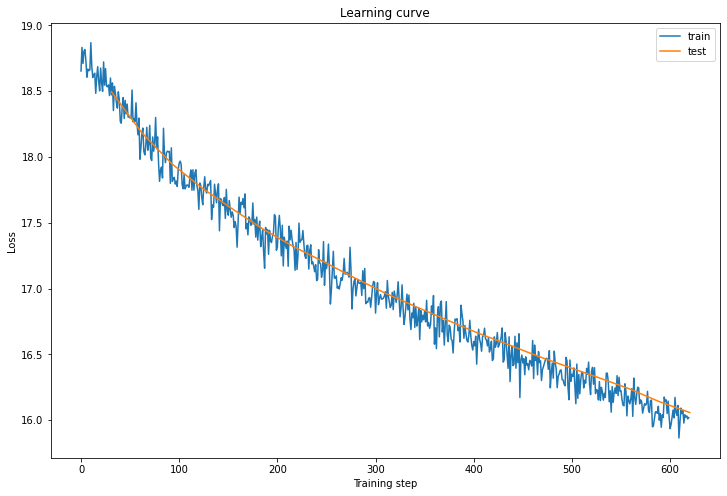

In [308]:
utils.show_learning_curve(train_metrics, test_metrics)

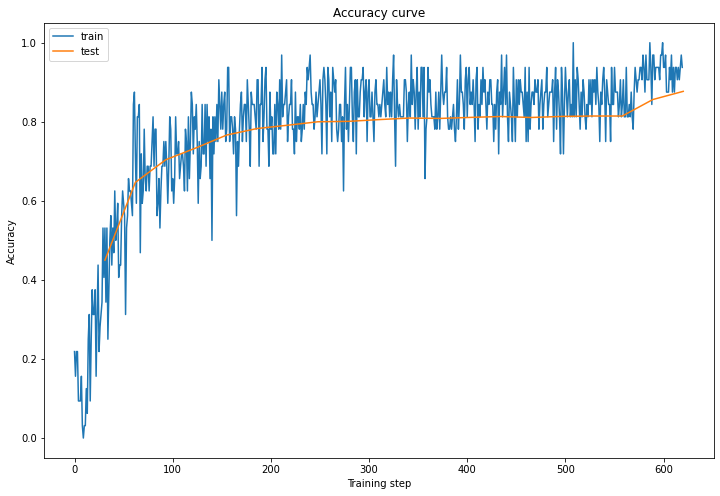

In [309]:
utils.show_accuracy_curve(train_metrics, test_metrics)

In [310]:
print(f"Best training accuracy: {max(train_metrics['acc'])}")
print(f"Best testing accuracy: {max(test_metrics['acc'])}")

Best training accuracy: 1.0
Best testing accuracy: 0.8769000172615051


In [311]:
num_samplings = 10
analyzer = utils.Analyzer(model, test_dataset, num_samplings)

Top high confidence correct predictions


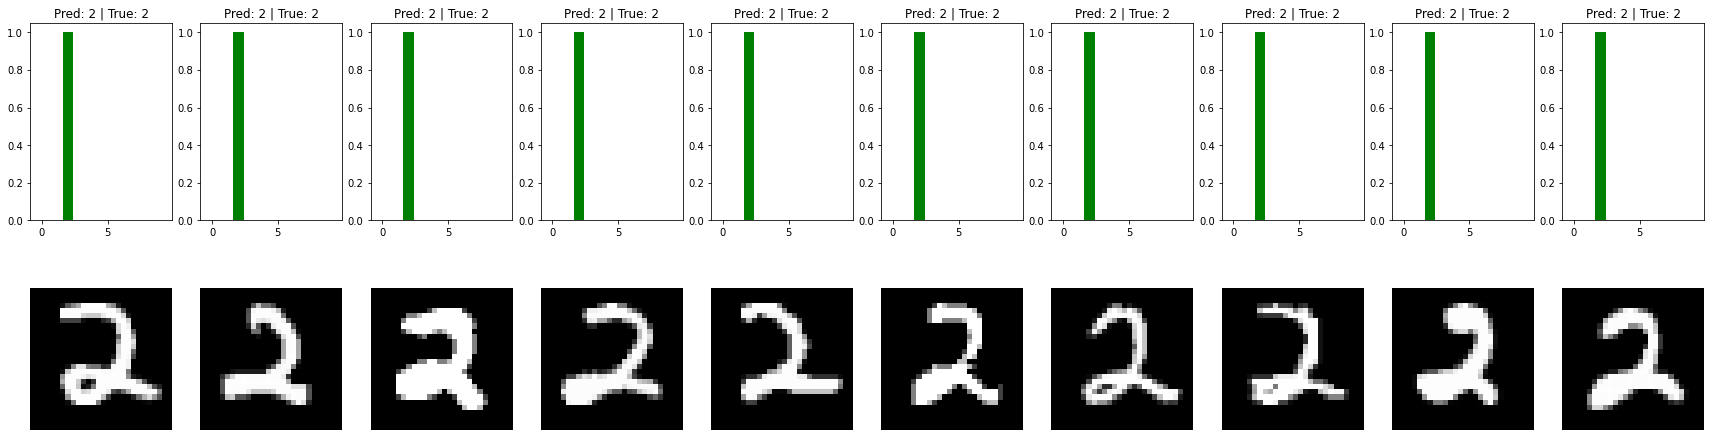

In [312]:
utils.visualize_samples(
    *analyzer.get_top_k_high_confidence_correct(10)
)
print("Top high confidence correct predictions")

Top low confidence correct predictions


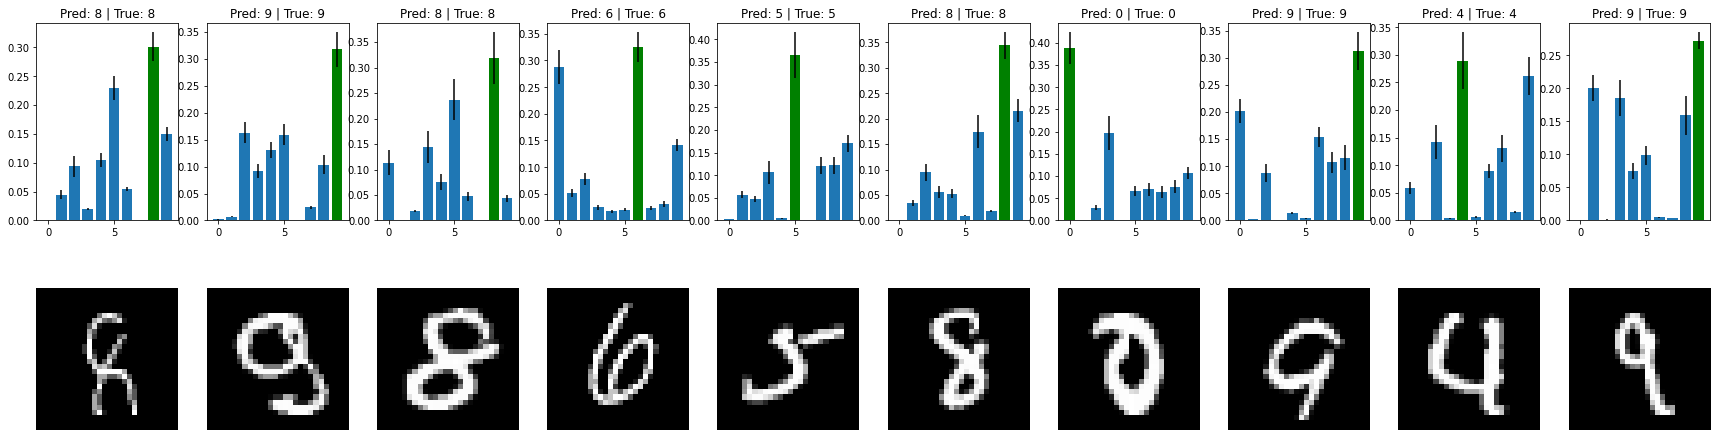

In [313]:
utils.visualize_samples(
    *analyzer.get_top_k_low_confidence_correct(10)
)
print("Top low confidence correct predictions")

Top low confidence wrong predictions


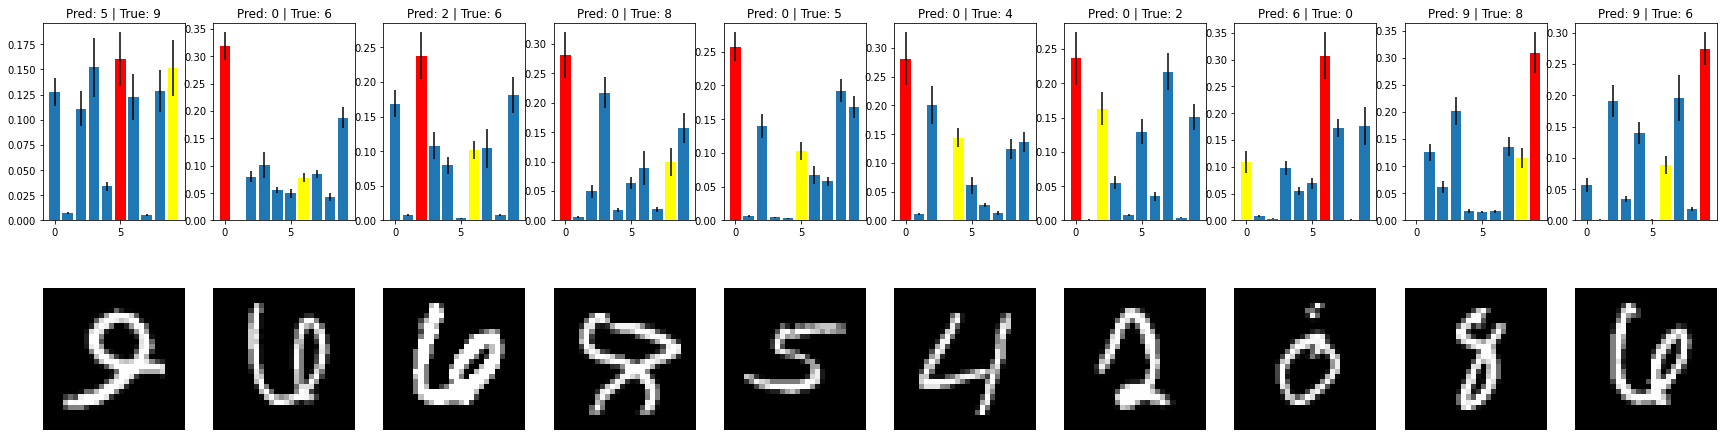

In [314]:
utils.visualize_samples(
    *analyzer.get_top_k_low_confidence_mistakes(10)
)

print("Top low confidence wrong predictions")

Top high confidence wrong predictions


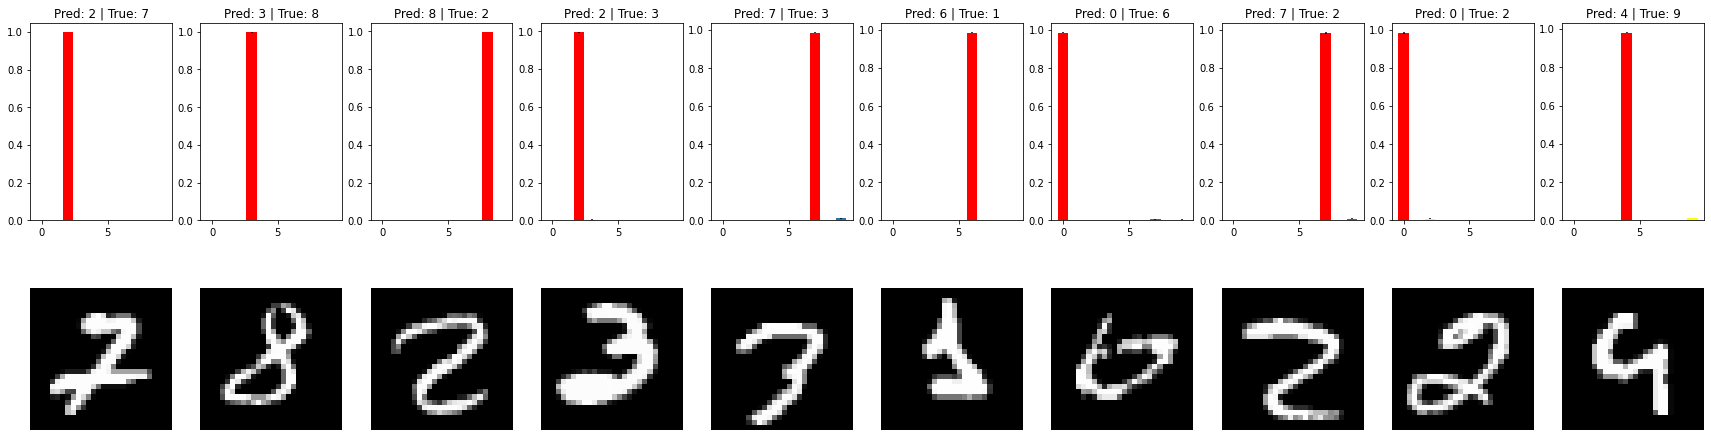

In [315]:
utils.visualize_samples(
    *analyzer.get_top_k_high_confidence_mistakes(10)
)

print("Top high confidence wrong predictions")

# Zadanie 3 (0.1 pkt)
Przypisz do zmiennych `layer_1_means` oraz `layer_2_means` wartości parametrów średnich rozkładu normalnego $\mu$ dla odpowiednio pierwszej i drugiej warstwy.

Histogram of weights for layer 1


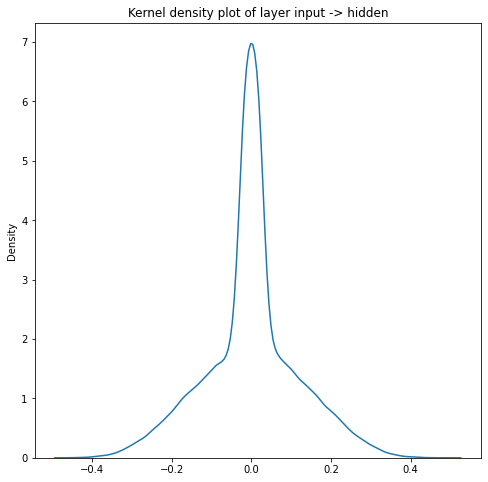

In [316]:
layer_1_means = model.layer_1.mu_w


utils.visualize_weights(layer_1_means, "layer input -> hidden")
print("Histogram of weights for layer 1")

Histogram of weights for layer 2


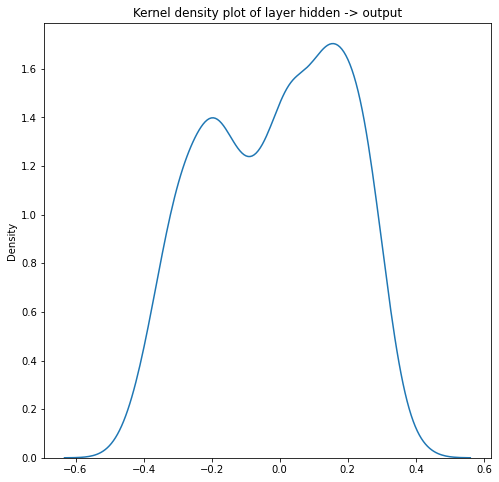

In [317]:
layer_2_means = model.layer_2.mu_w


utils.visualize_weights(layer_2_means, "layer hidden -> output")
print("Histogram of weights for layer 2")

# Zadanie 4 (1.4 pkt)
Zbadaj wpływ hiperparametrów na działanie modelu:
- parametry w rozkładzie prior (tzn. `sigma_1`, `sigma_2`, `mixing`)
- co się stanie jeśli zastosujemy tylko jeden rozkład normalny jako prior (zamiast mikstury)?
- rozmiar mini-paczki (`batch_size`)
- współczynnik uczenia (`learning_rate`)

In [ ]:
sigma_1 = [1, 0.2]
sigma_2 = [1, 0.2]
mixing = [0, 0.2]
batch_size = [25, 50]
learning_rate = [1e-3, 1e-2]
for sigma1 in sigma_1:
    for sigma2 in sigma_2:
        for m in mixing:
            for batch in batch_size:
                for lr in learning_rate:
                    train_metrics, test_metrics = utils.fit_elbo(
                        model= BayesianMLP(num_input_features=28 * 28, num_hidden_features=128, num_output_classes=10, sigma_1=sigma1, sigma_2=sigma2, mixing=m),
                        train_dataset=train_dataset,
                        valid_dataset=test_dataset,
                        loss_function=loss_fun,
                        batch_size=batch,
                        epochs=5,
                        optimizer=torch.optim.Adam(model.parameters(), lr=lr, ),
                    )
                    print(f"Params: sigma1:{sigma1}, sigma2:{sigma2}, mixing:{m}, batch:{batch}, lr:{lr}")
                    print(f"Best training accuracy: {max(train_metrics['acc'])}")
                    print(f"Best testing accuracy: {max(test_metrics['acc'])}")
                    

Epoch: 1 / 5



Epoch: 2 / 5
